In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os; os.chdir("..")
import pqr
os.chdir("./examples/")

# Предобработка данных

In [3]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":]

mcap = pd.read_csv("factors/russia/mcap.csv", parse_dates=True, index_col=0)["2003":]
pe = pd.read_csv("factors/russia/pe.csv", parse_dates=True, index_col=0)["2003":]

volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":]
volume = prices * volume  # convert volume from lots to money

prices, mcap, pe, volume = pqr.utils.replace_with_nan(prices, mcap, pe, volume)
prices, mcap, pe, volume = pqr.utils.align(prices, mcap, pe, volume)

In [4]:
universe = volume >= 1_000_000

benchmark = pqr.universe_as_benchmark(
    prices=prices,
    universe=universe,
)

In [5]:
table = pqr.utils.partial(
    pqr.metrics.show_table,
    metrics={
        "Monthly Mean Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_return,
            multiplier=100,
            statistics=True,
            annualizer=1,
        ),
        "Monthly Volatility, %": pqr.metrics.fancy_format(
            pqr.metrics.volatility,
            multiplier=100,
            annualizer=1,
        ),
        "Maximum Drawdown, %": pqr.metrics.fancy_format(
            pqr.metrics.max_drawdown,
            multiplier=100,
        ),
        "Sharpe Ratio": pqr.metrics.fancy_format(
            pqr.metrics.sharpe_ratio,
            rf=0,
        ),
        "Mean Excess Return, %": pqr.metrics.fancy_format(
            pqr.metrics.mean_excess_return,
            multiplier=100,
            benchmark=benchmark,
        ),
        "Alpha, %": pqr.metrics.fancy_format(
            pqr.metrics.alpha,
            multiplier=100,
            benchmark=benchmark,
            statistics=True,
        ),
        "Beta": pqr.metrics.fancy_format(
            pqr.metrics.beta,
            benchmark=benchmark,
        ),
    }
)
chart = pqr.utils.partial(
    pqr.metrics.plot_chart,
    metrics={
        "Compounded Returns": pqr.metrics.compounded_returns,
    },
    benchmark=benchmark,
    figsize=(16, 9),
)

summary = pqr.utils.partial(
    pqr.metrics.display_dashboard,
    items=[table, chart]
)

In [6]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.filter, universe=universe),
    pqr.utils.partial(pqr.look_back_mean, period=3),
    pqr.utils.partial(pqr.hold, period=3),
)
size = mean_transform(mcap)
value = mean_transform(pe)

Сначала строим однофакторные портфели по топ 20%

,Size,Value
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81)
"Monthly Volatility, %",9.27,7.86
"Maximum Drawdown, %",-80.45,-60.48
Sharpe Ratio,0.56,0.65
"Mean Excess Return, %",1.02,0.93
"Alpha, %",-0.01 (-0.00),1.50 (0.45)
Beta,1.06,0.97


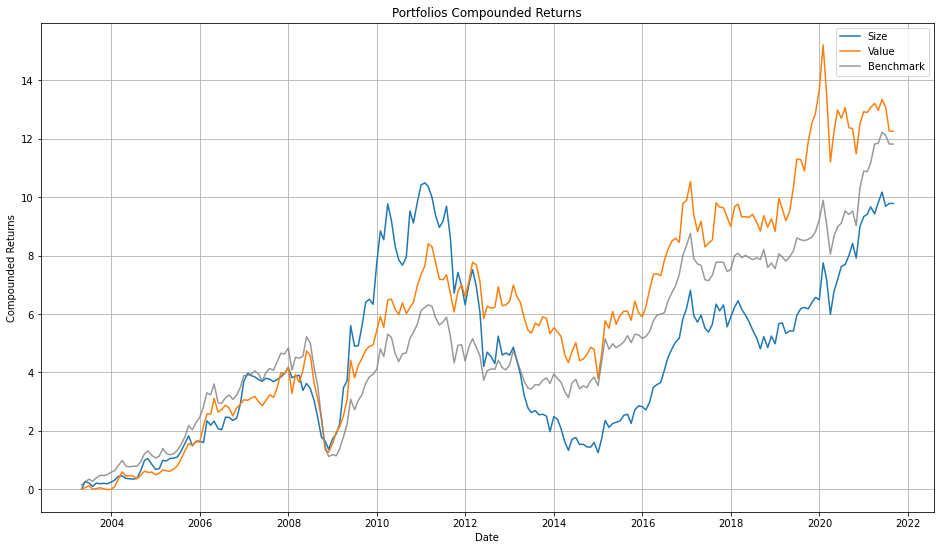

In [7]:
size_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(size, min_q=0, max_q=0.2),
    name="Size"
)

value_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(value, min_q=0, max_q=0.2),
    name="Value"
)

summary([size_portfolio, value_portfolio])

# Weighted Multifactor

Все просто - сводим мульифакторный выбор к 1-факторному

,Size,Value,Size + Value Weighted
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81),1.65*** (2.68)
"Monthly Volatility, %",9.27,7.86,9.16
"Maximum Drawdown, %",-80.45,-60.48,-73.75
Sharpe Ratio,0.56,0.65,0.63
"Mean Excess Return, %",1.02,0.93,2.97
"Alpha, %",-0.01 (-0.00),1.50 (0.45),1.99 (0.44)
Beta,1.06,0.97,1.06


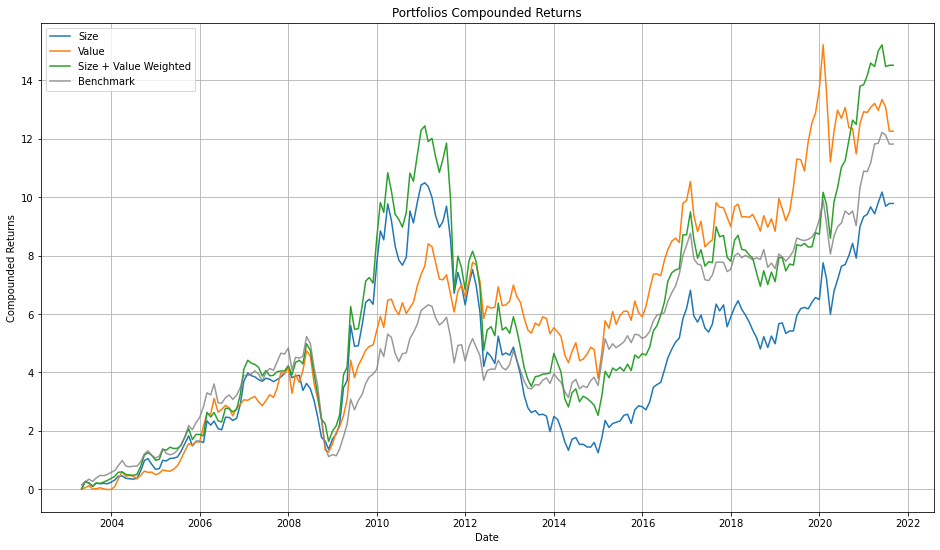

In [8]:
size_value_weighted_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(0.5 * size + 0.5 * value, min_q=0, max_q=0.2),
    name="Size + Value Weighted"
)
summary([size_portfolio, value_portfolio, size_value_weighted_portfolio])

# Intercept Multifactor

,Size,Value,Size + Value Weighted,Size + Value Intercept
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81),1.65*** (2.68),1.46*** (2.35)
"Monthly Volatility, %",9.27,7.86,9.16,9.24
"Maximum Drawdown, %",-80.45,-60.48,-73.75,-69.11
Sharpe Ratio,0.56,0.65,0.63,0.55
"Mean Excess Return, %",1.02,0.93,2.97,0.67
"Alpha, %",-0.01 (-0.00),1.50 (0.45),1.99 (0.44),8.42 (1.21)
Beta,1.06,0.97,1.06,0.54


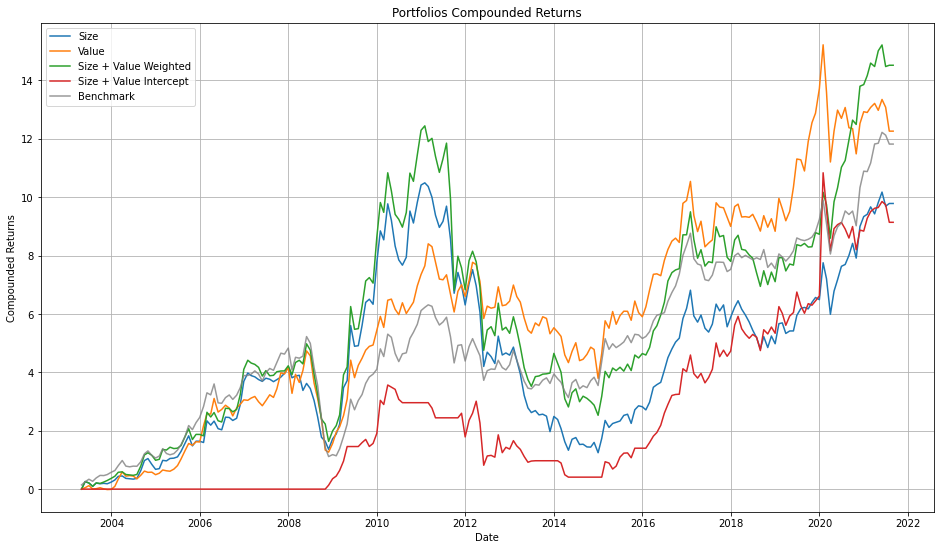

In [9]:
size_value_intercept_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=pqr.quantiles(size, min_q=0, max_q=0.2) & pqr.quantiles(value, min_q=0, max_q=0.2),
    name="Size + Value Intercept"
)

summary([
    size_portfolio, 
    value_portfolio, 
    size_value_weighted_portfolio, 
    size_value_intercept_portfolio
])

# Double Sort Multifactor

,Size,Value,Size + Value Weighted,Size + Value Intercept,Size -> Value Double Sort,Value -> Size Double Sort
"Monthly Mean Return, %",1.49*** (2.39),1.48*** (2.81),1.65*** (2.68),1.46*** (2.35),2.50*** (2.61),2.30*** (2.96)
"Monthly Volatility, %",9.27,7.86,9.16,9.24,14.26,11.58
"Maximum Drawdown, %",-80.45,-60.48,-73.75,-69.11,-82.88,-69.93
Sharpe Ratio,0.56,0.65,0.63,0.55,0.61,0.69
"Mean Excess Return, %",1.02,0.93,2.97,0.67,13.16,10.77
"Alpha, %",-0.01 (-0.00),1.50 (0.45),1.99 (0.44),8.42 (1.21),5.40 (0.65),8.49 (1.21)
Beta,1.06,0.97,1.06,0.54,1.46,1.13


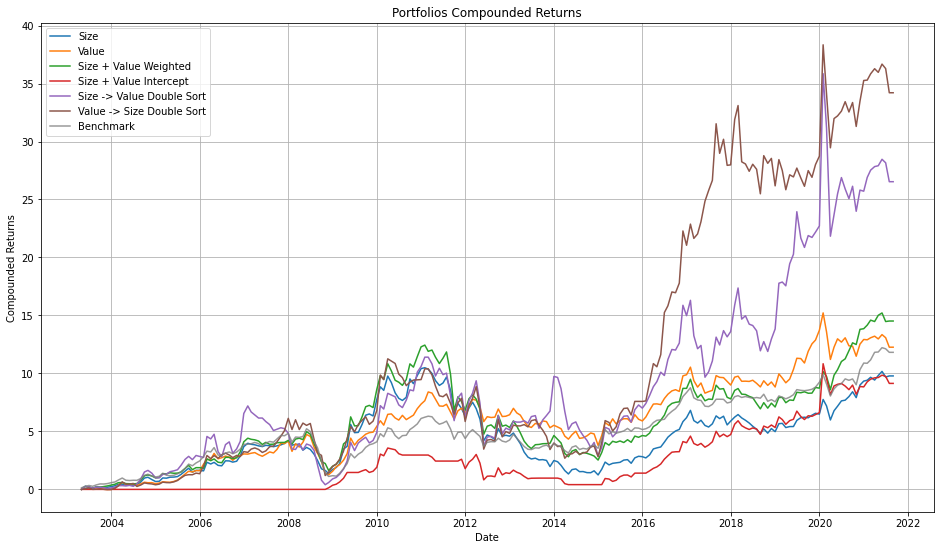

In [10]:
def double_sort(f1, f2):
    return pqr.quantiles(
        pqr.filter(f2, universe=pqr.quantiles(f1, min_q=0, max_q=0.2)),
        min_q=0,
        max_q=0.2,
    )

size_value_double_sort_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=double_sort(size, value),
    name="Size -> Value Double Sort",
)

value_size_double_sort_portfolio = pqr.backtest_portfolio(
    prices=prices,
    longs=double_sort(value, size),
    name="Value -> Size Double Sort",
)

summary([
    size_portfolio, value_portfolio, 
    size_value_weighted_portfolio, 
    size_value_intercept_portfolio,
    size_value_double_sort_portfolio,
    value_size_double_sort_portfolio
])